# loading the data :

In [0]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


# Dog detector : 

In [0]:
from keras.applications.resnet50 import ResNet50

ResNet50_model = ResNet50(weights='imagenet')

In [0]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) because de resnet50 needs this shape to work !
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [0]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

In [0]:
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

the accuracy of the detector :

In [0]:
dog_faces = [dog_detector(dog_file) for dog_file in dog_files_short]
percentage_dog = 100 * (np.sum(dog_faces)/len(dog_faces))
        
print('There are %.1f%% images of the first 100 dog_files that have a detected dog face.' % percentage_dog)



```
there are 100.0% images of the first 100 dog_files that have a detected dog face.
```



# Dog breed classifier from scratch :

In [0]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:06<00:00, 136.09it/s]


Creating the architecture :

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 64)        0         
__________

In [0]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Training the model :

In [0]:
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen_train = ImageDataGenerator(
    width_shift_range=0.1,  
    height_shift_range=0.1,  
    horizontal_flip=True) # randomly flip images horizontally

datagen_valid = ImageDataGenerator(
    width_shift_range=0.1,  
    height_shift_range=0.1,  
    horizontal_flip=True) # randomly flip images horizontally

datagen_train.fit(train_tensors)
datagen_valid.fit(valid_tensors)

In [0]:
from keras.callbacks import ModelCheckpoint  

epochs = 5
batch_size = 20

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit_generator(datagen_train.flow(train_tensors, train_targets, batch_size=batch_size),
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, verbose=1, callbacks=[checkpointer],
                    validation_data=datagen_valid.flow(valid_tensors, valid_targets, batch_size=batch_size),
                    validation_steps=valid_tensors.shape[0] // batch_size)

Epoch 1/5
334/334 [==============================] - 62s - loss: 4.8941 - acc: 0.0178 - val_loss: 4.6413 - val_acc: 0.0439
Epoch 2/5
334/334 [==============================] - 60s - loss: 4.5102 - acc: 0.0409 - val_loss: 4.3557 - val_acc: 0.0549
Epoch 3/5
334/334 [==============================] - 61s - loss: 4.3030 - acc: 0.0560 - val_loss: 4.2061 - val_acc: 0.0805
Epoch 4/5
334/334 [==============================] - 60s - loss: 4.1358 - acc: 0.0778 - val_loss: 4.0945 - val_acc: 0.0854
Epoch 5/5
334/334 [==============================] - 62s - loss: 4.0348 - acc: 0.0886 - val_loss: 4.0681 - val_acc: 0.0890


In [0]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

In [0]:
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 9.3301%


the accuracy is low because we created our own CNN and trained it with a small amount of data. We can improve it a lot by using a pre-trained convolution network and train it on our data.

I used the Xception network because it has been suggested a lot in a lot of forums.

# Creating the architecture using transfer learning with the dog Xception pre-trained convolutional network 

In [0]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogXceptionData.npz')
train_Xception = bottleneck_features['train']
valid_Xception = bottleneck_features['valid']
test_Xception = bottleneck_features['test']

adding a fully connected network (FCN) at the end of the Xception network with the global average pooling as the input of the FCN

In [0]:
### TODO: Define your architecture.
from keras.layers import Dropout

Xception_model = Sequential()
Xception_model.add(GlobalAveragePooling2D(input_shape=train_Xception.shape[1:]))
Xception_model.add(Dense(500, activation='relu'))
Xception_model.add(Dropout(0.4))
Xception_model.add(Dense(133, activation='softmax'))

Xception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 500)               1024500   
_________________________________________________________________
dropout_3 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 133)               66633     
Total params: 1,091,133.0
Trainable params: 1,091,133.0
Non-trainable params: 0.0
_________________________________________________________________


In [0]:
from keras.optimizers import SGD

Xception_model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.002), metrics=['accuracy'])

training the model

In [0]:
from keras.preprocessing.image import ImageDataGenerator

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', 
                               verbose=1, save_best_only=True)

Xception_model.fit(train_Xception, train_targets, 
          validation_data=(valid_Xception, valid_targets),
          epochs=120, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/120
6680/6680 [==============================] - 4s - loss: 4.7883 - acc: 0.0341 - val_loss: 4.5273 - val_acc: 0.1198
Epoch 2/120
6680/6680 [==============================] - 4s - loss: 4.3615 - acc: 0.1503 - val_loss: 4.1187 - val_acc: 0.3521
Epoch 3/120
6680/6680 [==============================] - 4s - loss: 3.9432 - acc: 0.3141 - val_loss: 3.6749 - val_acc: 0.4994
Epoch 4/120
6680/6680 [==============================] - 4s - loss: 3.5010 - acc: 0.4398 - val_loss: 3.2080 - val_acc: 0.5737
Epoch 5/120
6680/6680 [==============================] - 4s - loss: 3.0534 - acc: 0.5247 - val_loss: 2.7571 - val_acc: 0.6251
Epoch 6/120
6680/6680 [==============================] - 4s - loss: 2.6476 - acc: 0.5777 - val_loss: 2.3551 - val_acc: 0.6671
Epoch 7/120
6680/6680 [==============================] - 4s - loss: 2.2822 - acc: 0.6175 - val_loss: 2.0140 - val_acc: 0.6934
Epoch 8/120
6680/6680 [==============================] - 4s - loss: 1.9

6680/6680 [==============================] - 4s - loss: 0.6879 - acc: 0.8219 - val_loss: 0.6249 - val_acc: 0.8371
Epoch 27/120
6680/6680 [==============================] - 4s - loss: 0.6756 - acc: 0.8159 - val_loss: 0.6121 - val_acc: 0.8407
Epoch 28/120
6680/6680 [==============================] - 4s - loss: 0.6593 - acc: 0.8251 - val_loss: 0.6022 - val_acc: 0.8455
Epoch 29/120
6680/6680 [==============================] - 4s - loss: 0.6422 - acc: 0.8295 - val_loss: 0.5924 - val_acc: 0.8443
Epoch 30/120
6680/6680 [==============================] - 4s - loss: 0.6388 - acc: 0.8275 - val_loss: 0.5840 - val_acc: 0.8479
Epoch 31/120
6680/6680 [==============================] - 4s - loss: 0.6220 - acc: 0.8346 - val_loss: 0.5766 - val_acc: 0.8479
Epoch 32/120
6680/6680 [==============================] - 4s - loss: 0.6126 - acc: 0.8374 - val_loss: 0.5698 - val_acc: 0.8479
Epoch 33/120
6680/6680 [==============================] - 4s - loss: 0.5951 - acc: 0.8386 - val_loss: 0.5629 - val_acc: 0.84

6680/6680 [==============================] - 4s - loss: 0.4581 - acc: 0.8731 - val_loss: 0.4926 - val_acc: 0.8503
Epoch 53/120
6680/6680 [==============================] - 4s - loss: 0.4567 - acc: 0.8732 - val_loss: 0.4895 - val_acc: 0.8515
Epoch 54/120
6680/6680 [==============================] - 4s - loss: 0.4517 - acc: 0.8687 - val_loss: 0.4866 - val_acc: 0.8491
Epoch 55/120
6680/6680 [==============================] - 4s - loss: 0.4539 - acc: 0.8719 - val_loss: 0.4858 - val_acc: 0.8503
Epoch 56/120
6680/6680 [==============================] - 4s - loss: 0.4396 - acc: 0.8762 - val_loss: 0.4834 - val_acc: 0.8491
Epoch 57/120
6680/6680 [==============================] - 4s - loss: 0.4348 - acc: 0.8814 - val_loss: 0.4820 - val_acc: 0.8527
Epoch 58/120
6680/6680 [==============================] - 4s - loss: 0.4320 - acc: 0.8789 - val_loss: 0.4801 - val_acc: 0.8527
Epoch 59/120
6680/6680 [==============================] - 4s - loss: 0.4315 - acc: 0.8780 - val_loss: 0.4779 - val_acc: 0.85

6680/6680 [==============================] - 4s - loss: 0.3653 - acc: 0.8940 - val_loss: 0.4566 - val_acc: 0.8527
Epoch 78/120
6680/6680 [==============================] - 4s - loss: 0.3627 - acc: 0.8981 - val_loss: 0.4562 - val_acc: 0.8527
Epoch 79/120
6680/6680 [==============================] - 4s - loss: 0.3707 - acc: 0.8928 - val_loss: 0.4550 - val_acc: 0.8539
Epoch 80/120
6680/6680 [==============================] - 4s - loss: 0.3558 - acc: 0.8999 - val_loss: 0.4542 - val_acc: 0.8503
Epoch 81/120
6680/6680 [==============================] - 4s - loss: 0.3583 - acc: 0.8982 - val_loss: 0.4538 - val_acc: 0.8515
Epoch 82/120
6680/6680 [==============================] - 4s - loss: 0.3500 - acc: 0.9003 - val_loss: 0.4531 - val_acc: 0.8539
Epoch 83/120
6680/6680 [==============================] - 4s - loss: 0.3576 - acc: 0.8993 - val_loss: 0.4512 - val_acc: 0.8539
Epoch 84/120
6680/6680 [==============================] - 4s - loss: 0.3569 - acc: 0.8952 - val_loss: 0.4514 - val_acc: 0.85

6680/6680 [==============================] - 4s - loss: 0.3037 - acc: 0.9126 - val_loss: 0.4397 - val_acc: 0.8503
Epoch 104/120
6680/6680 [==============================] - 4s - loss: 0.3031 - acc: 0.9139 - val_loss: 0.4393 - val_acc: 0.8515
Epoch 105/120
6680/6680 [==============================] - 4s - loss: 0.3002 - acc: 0.9130 - val_loss: 0.4383 - val_acc: 0.8551
Epoch 106/120
6680/6680 [==============================] - 4s - loss: 0.3028 - acc: 0.9133 - val_loss: 0.4385 - val_acc: 0.8515
Epoch 107/120
6680/6680 [==============================] - 4s - loss: 0.3019 - acc: 0.9132 - val_loss: 0.4396 - val_acc: 0.8515
Epoch 108/120
6680/6680 [==============================] - 4s - loss: 0.2973 - acc: 0.9162 - val_loss: 0.4384 - val_acc: 0.8563
Epoch 109/120
6680/6680 [==============================] - 4s - loss: 0.2987 - acc: 0.9163 - val_loss: 0.4399 - val_acc: 0.8551
Epoch 110/120
6680/6680 [==============================] - 4s - loss: 0.2968 - acc: 0.9154 - val_loss: 0.4380 - val_ac

In [0]:
Xception_model.load_weights('saved_models/weights.best.Xception.hdf5')

In [0]:
Xception_predictions = [np.argmax(Xception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Xception]

test_accuracy = 100*np.sum(np.array(Xception_predictions)==np.argmax(test_targets, axis=1))/len(Xception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 85.4067%


In [0]:
def Xception_predict_breed(img_path):
    bottleneck_feature = extract_Xception(path_to_tensor(img_path))
    predicted_vector = Xception_model.predict(bottleneck_feature)
    return dog_names[np.argmax(predicted_vector)]

In [0]:
def display_img(img_path):
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(cv_rgb)

def predict_breed(img_path):
    display_img(img_path)
    if dog_detector(img_path):
        print("I detected a dog!")
        return print("The breed of this beautiful dog is a {}".format(Xception_predict_breed(img_path)))        
    else:
        return print("Hum... No dog has been detected.")

# Results of the model :

I detected a dog!
The breed of this beautiful dog is a Labrador_retriever


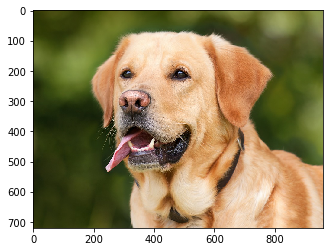

In [0]:
predict_breed('images/test_dog_1.jpg')

I detected a dog!
The breed of this beautiful dog is a Pomeranian


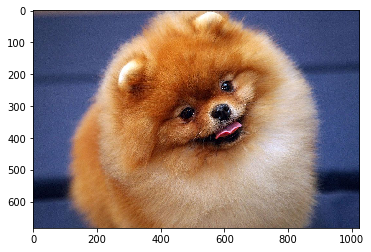

In [0]:
predict_breed('images/test_dog_2.jpg')

I detected a dog!
The breed of this beautiful dog is a Briard


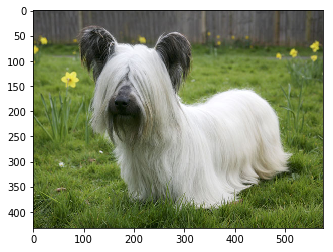

In [0]:
predict_breed('images/test_dog_8.jpg')